In [ ]:
# pip install keras-tuner

## Essential libraries and modules.

This project uses the following modules/libraries. <br>
- Pandas for data manipulation.
- sklearn for data splitting.
- Several Keras modules for building and training the CNN model.
- keras_tuner for optimizing the model's hyperparameters.

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras_tuner import HyperModel
from tensorflow.keras.optimizers.legacy import Adam  # Use legacy Adam since we are using Mac M1/M2 - 
from keras_tuner.tuners  import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger


## Load data
The dataset contains classification and paths to images which is first loaded into a pandas DataFrame. <br>
The two main columns:
- **image_filename** For the image filenames.
- **bethesda_system** That corresponds to image labels which are classified into 6 classes:
    - ASC-US - Negative for intraepithelial lesion.
    - ASC-H - Atypical squamous cells of undetermined significance.
    - LSIL - Atypical squamous cells cannot exclude HSIL.
    - HSIL - Low grade squamous intraepithelial lesion.
    - SCC - High grade squamous intraepithelial lesion. <br>
    
Images are stored seperately in a **images** directory.


In [72]:
# Load dataset
data_path = 'data/classifications.csv'
data = pd.read_csv(data_path)

# Directory where images are stored
image_dir = 'data/images/'


## Split data
The dataset is split into training and testing subsets using train_test_split from scikit-learn, with 20% of the data reserved for testing.

In [73]:
# Split the data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)


## Data preprocessing and Augmentation

The first step is to prepare the image data for training through normalization, rescaling, and augmentation of these images from image files on disk. <br>
This approach is memory efficient as it dynamically loads and processes images in batches during training, rather than loading the entire dataset into memory at once. <br>
This step is broken down into the following:

**1. Rescaling the Pixel Values:** Training, Validation and Testing images are rescaled by 1./255, converting the pixel values from the range [0, 255] to [0, 1]. This normalization step helps in speeding up the training process and reaching convergence faster. <br>

**2. Split the Training Data:** The training data is further partitioned into training and validation subsets using a **validation_split of 0.2**. <br>
This 20% validation dataset is essential for evaluating the model's performance on unseen data during training without touching the test set. <br>

**3. Data Generators:** We use the **flow_from_dataframe** method to load images directly from a pandas DataFrame. The image filenames and corresponding labels are stored in a DataFrame, while the image files are stored in filesystem directories. This step allows for easy integration with the model training process. <br>

The overall goal of this section is to set up an efficient pipeline for feeding image data into the CNN model. This helps to achieve the following objectives: <br>
- Dynamically loading and preprocessing image data from disk to reduce memory usage.
- Normalizing image pixel values to aid in model training.
- Partitioning the training data into training and validation subsets for model validation.
- Ensuring that the model can be evaluated on unseen test data.

In [74]:
# Initialize ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)


# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_filename',
    y_col='bethesda_system',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_filename',
    y_col='bethesda_system',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='image_filename',
    y_col='bethesda_system',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation: the data should not be shuffled.
)

Found 7382 validated image filenames belonging to 6 classes.
Found 1845 validated image filenames belonging to 6 classes.
Found 2307 validated image filenames belonging to 6 classes.


## Defining CNN Model
The **CNNHyperModel** class is designed for hyperparameter tuning of a Convolutional Neural Network (CNN) model using Keras Tuner. It inherits from **HyperModel** Keras Tuner base class to define the hyperparameters to be optimized. <br>

**input_shape:** The shape of the input images which is crucial for the first layer of the CNN to know the input shape it will be receiving. <br>
**num_classes:** The number of output classes which is required by the output layer and maps to the probability distribution across the classes.<br>
**build Method:** The method builds the CNN model with a flexible architecture based on hyperparameters selected during the tuning process. <br>

### Model Architecture
**1. Convolutional Layers** The has two convolutional layers (Conv2D) of 32 and 64 filters, respectively. Each layer uses a 3x3 kernel. The activation function for these layers is chosen from ['relu', 'tanh', 'sigmoid'] based on the tuning process. <br>

**2. Pooling Layers** Each convolutional layer has a max pooling layer (MaxPooling2D) with a pool size of 2x2. This helps reduce the spatial dimensions of the output from the preceding convolutional layer, reducing the number of parameters and computation in the network, and also helps to control overfitting. <br>
**3. Flattening** The Flatten layer transforms the 2D matrix data to a vector. This allows the output from convolutional and pooling layers to be fed into dense layers. <br>
**4. Dense Layer** A dense layer with 512 units is added, serving as a fully connected layer that learns global patterns in the spatial hierarchy of the features extracted by the preceding layers. <br>
**5. Dropout** A Dropout layer with a rate of 0.5 is used to prevent overfitting. It randomly sets input units to 0 at each update during training time, which helps to prevent overfitting by making the learning process noisy. <br>
**6. Output Layer** The final layer is a dense layer with a number of units equal to the number of classes. It uses the softmax activation function to output the probability distribution over the classes. <br>

### Compilation
The model is compiled with the Adam optimizer, where the learning rate is tuned between 0.0001 and 0.01 with logarithmic sampling. This ensures that the learning rate values are chosen in a way that evenly spaces their logarithms within this range. <br>

The **categorical_crossentropy** is suitable for multi-class classification tasks. <br>
The **accuracy** metric used to evaluate the model. 

In [76]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid']),
                         input_shape=self.input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(units=512, activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])))
        model.add(Dropout(rate=0.5))
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile model
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

## Hyperparameters tuning

This section helps to define, initialize, and execute the hyperparameter tuning process. <br>
The first two variables:<br> 
### Variables Definition
**1. max_trial = 2** Specifies the maximum number of different hyperparameter configurations to try during the tuning process. <br>
**2. epoch = 5:** The number of times the model will iterate over the entire training dataset during the training process for each trial.<br>

### Hypermodel Definition
**CNNHyperModel** is initialized by specifying the input shape of the images (150x150 pixels with 3 channels for RGB) and the number of classes to predict. The number of classes is dynamically set based on the training data. <br>

### Tuner Initialization
The RandomSearch tuner is instantiated with several parameters:
**1. hypermodel:** The model to be tuned.
**2. objective='val_accuracy':** The tuner will aim to maximize and optimize the validation accuracy.<br>
**3. max_trials=max_trial:** The maximum number of trials to run, specified by the max_trial variable. <br>
**4. executions_per_trial=1:** Each model configuration is training these number of times (in this case we trained each model once).<br>
**5. directory='hyperparam_tuning':** The directory where the tuning results will be stored.
**6. project_name='cervix_classification':** The name of the tuning project that helps in organizing and retrieving the tuning results.

### Early Stopping Callback

The **EarlyStopping callback** helps to prevent overfitting. Training will stop if the validation loss does not improve for five epochs, helping to save time and computational resources. You can always change the number of epochs to suit your model.

### Hyperparameter Tuning Execution

The **tuner.search(...)** executes the tuning process by training the model with the training data and evaluating it using the validation datafor a specified number of epochs. The search method automatically tests different hyperparameter configurations based on the definitions in the CNNHyperModel class. <br>

### Fetching and Displaying Best Hyperparameters
We use the **tuner.get_best_hyperparameters(num_trials=1)[0]** to retrieve the best set of hyperparameters after the tuning process completes. <br>

This section takes care of the hyperparameter tuning process, from the definition of hypermodel parameters and the tuning strategy to the execution of the search and the presentation of the best results.


In [79]:
# Variables 
max_trial = 2
epoch = 5
# Define the hypermodel
hypermodel = CNNHyperModel(input_shape=(150, 150, 3), num_classes=len(train_generator.class_indices))

# Initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=max_trial,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cervix_classification'
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Perform hyperparameter tuning
tuner.search(train_generator, 
             epochs=epoch, 
             validation_data=validation_generator)

# Fetch the best performing hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the hyperparameter values
print("Best Hyperparameters : \n")
for hp in best_hps.space:
    print(f"{hp.name}: {best_hps.get(hp.name)}")



Trial 2 Complete [00h 36m 51s]
val_accuracy: 0.578319787979126

Best val_accuracy So Far: 0.578319787979126
Total elapsed time: 01h 13m 34s
Best Hyperparameters : 

activation: sigmoid
learning_rate: 0.003256343224504914


## Training the Best Model 
After hyperparameter tuning, the best hyperparameters are applied to rebuild the optimal model. <br>
This model is then trained on the full training set, including both training and validation subsets, for a specified number of epochs.

In [80]:
# Build the model with the optimal hyperparameters and train it on the data for given epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generator, epochs=epoch, validation_data=validation_generator)


Epoch 1/5
231/231 [==============================] - 442s 2s/step - loss: 1.5379 - accuracy: 0.5374 - val_loss: 1.4837 - val_accuracy: 0.5783
Epoch 2/5
231/231 [==============================] - 440s 2s/step - loss: 1.3570 - accuracy: 0.5761 - val_loss: 1.3223 - val_accuracy: 0.5783
Epoch 3/5
231/231 [==============================] - 441s 2s/step - loss: 1.3381 - accuracy: 0.5853 - val_loss: 1.3278 - val_accuracy: 0.5783
Epoch 4/5
231/231 [==============================] - 437s 2s/step - loss: 1.3357 - accuracy: 0.5824 - val_loss: 1.3167 - val_accuracy: 0.5783
Epoch 5/5
231/231 [==============================] - 447s 2s/step - loss: 1.3325 - accuracy: 0.5845 - val_loss: 1.3011 - val_accuracy: 0.5783


## Loss Curves

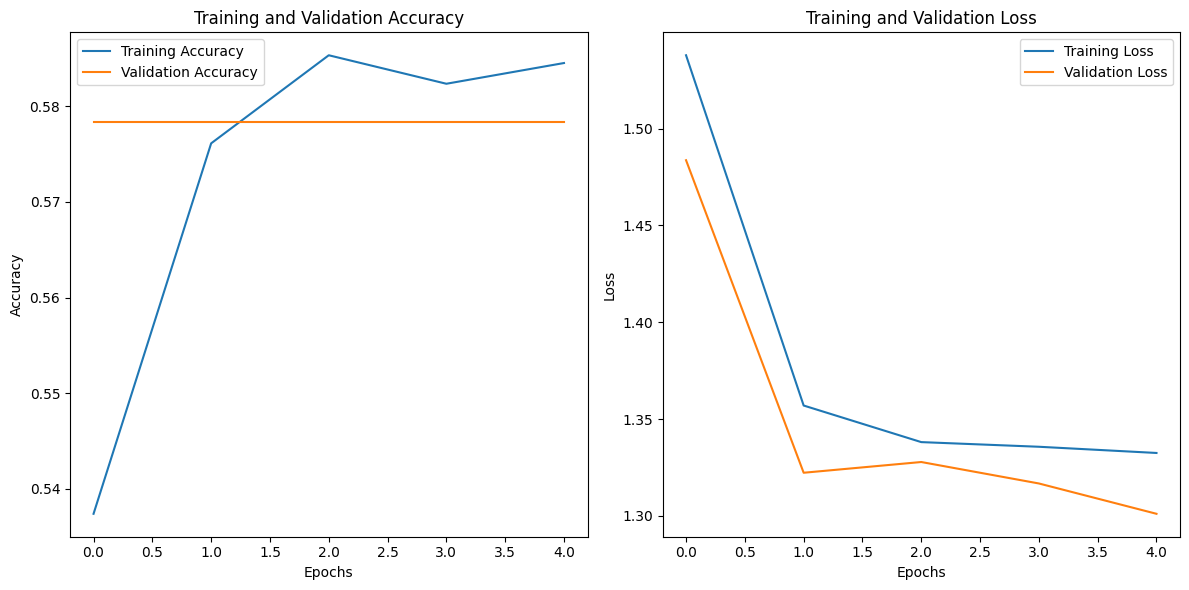

In [81]:
# Plot the loss curves
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The **history.history** dictionary contains training/validation results. <br>
We create a DataFrame to display the results. <br>


In [82]:
# Convert history.history dictionary to a DataFrame a
df_history_with = pd.DataFrame(history.history).reset_index().rename(columns={'index': 'epoch'})

df_history_with['epoch'] += 1 # Since Index start at 0, we add 1 to represent epoch values.

df_history_with


,epoch,loss,accuracy,val_loss,val_accuracy
0,1,1.537919,0.537388,1.483707,0.57832
1,2,1.356987,0.576131,1.322262,0.57832
2,3,1.338088,0.585343,1.327804,0.57832
3,4,1.335685,0.582363,1.316722,0.57832
4,5,1.332479,0.584530,1.301057,0.57832


In [83]:
# Find the record with the minimum val_loss
min_val_loss = df_history_with_epoch.loc[df_history_with_epoch['val_loss'].idxmin()]

print("The best performing results: \n")
print(f"Epoch : {int(min_val_loss.epoch)}")
print(f"Training Accuracy : {min_val_loss.accuracy:.4f}")
print(f"Training Loss : {min_val_loss.loss:.4f}")
print(f"Validation Accuracy : {min_val_loss.val_accuracy:.4f}")
print(f"Validation Loss : {min_val_loss.val_loss:.4f}")


The best performing results: 

Epoch : 4
Training Accuracy : 0.5719
Training Loss : 1.3811
Validation Accuracy : 0.5783
Validation Loss : 1.3040


## Model Evaluation on Test data
Finally we evaluate the model on the unseen test data to measure its performance, specifically looking at accuracy and loss metrics.

In [84]:
# Evaluate the model on test data
eval_result = model.evaluate(test_generator)

print("Model performance on Test Dataset : \n")
print(f'Test Accuracy : {eval_result[1]:.4f}')
print(f'Test loss : {eval_result[0]:.4f}')


73/73 [==============================] - 103s 1s/step - loss: 1.2799 - accuracy: 0.5878
Model performance on Test Dataset : 

Test Accuracy : 0.5878
Test loss : 1.2799
